In [1]:
# Step 1: Upload Dataset
from google.colab import files
uploaded = files.upload()
import os
print("Files in working directory:", os.listdir())

Saving Phishing_Email.csv to Phishing_Email.csv
Files in working directory: ['.config', 'Phishing_Email.csv', 'sample_data']


In [2]:
# Step 2: Install Required Libraries
!pip install seaborn scikit-learn

In [3]:
# Step 3: Import Libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tensorflow as tf

from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, f1_score, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score
)
from tensorflow import keras
from tensorflow.keras import layers

Initial shape: (10000, 50)


/tmp/ipython-input-2477518817.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="CLASS_LABEL", data=df, palette="Set2")


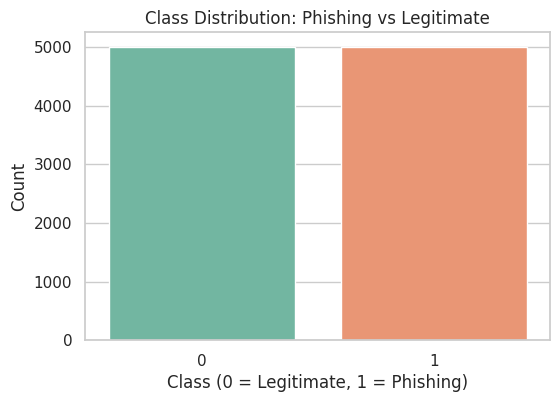

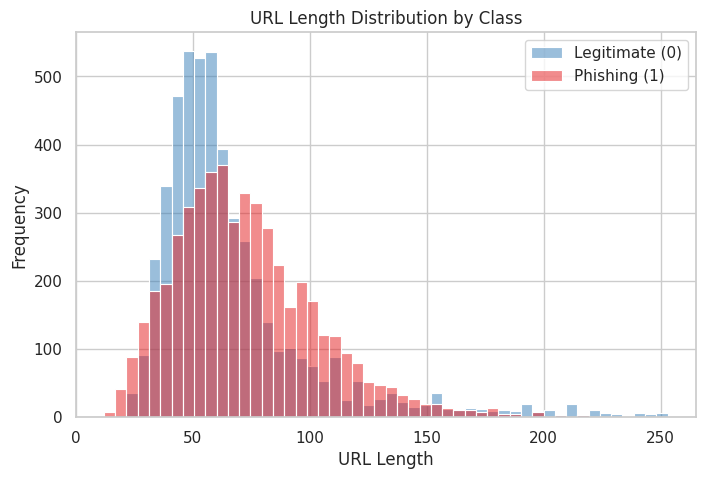

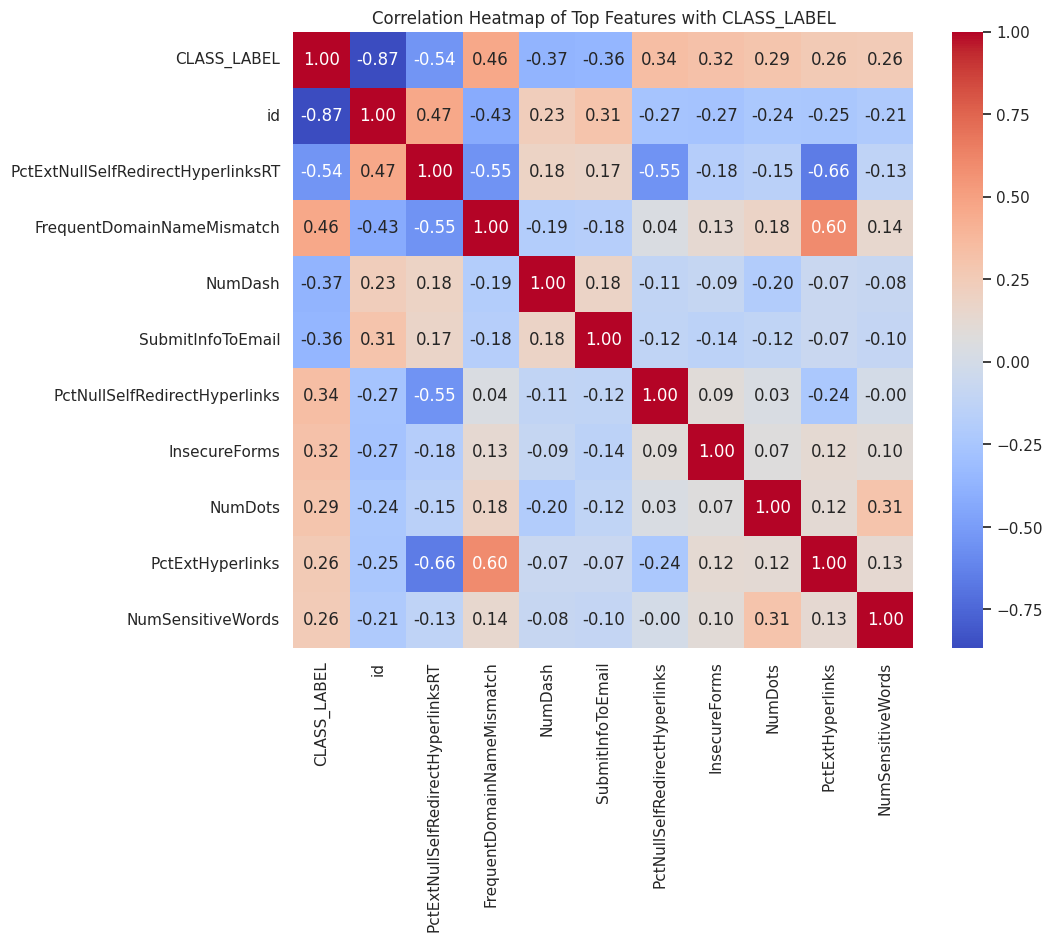

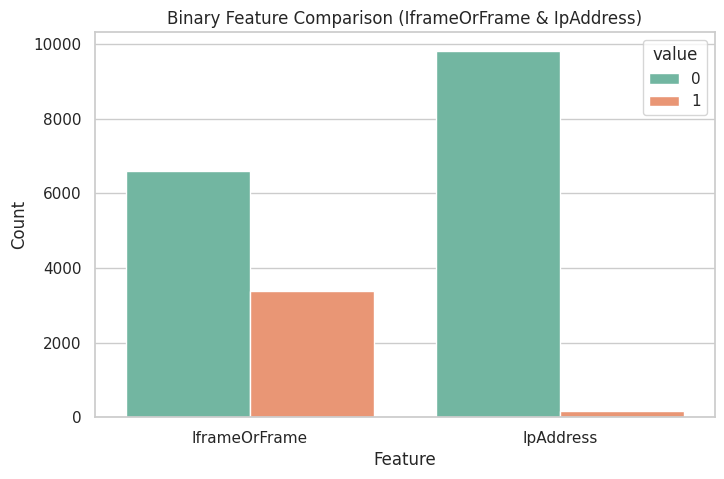

In [4]:
# Step 4: Load Dataset
df = pd.read_csv('Phishing_Email.csv')
df = df.drop(columns=['Unnamed: 0'], errors='ignore')
print('Initial shape:', df.shape)
df.head()
# ===============================
# Exploratory Data Analysis (EDA)
# ===============================

# Set plot style
sns.set(style="whitegrid")

# 1. Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="CLASS_LABEL", data=df, palette="Set2")
plt.title("Class Distribution: Phishing vs Legitimate")
plt.xlabel("Class (0 = Legitimate, 1 = Phishing)")
plt.ylabel("Count")
plt.show()

# 2. URL Length Distribution
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="UrlLength", hue="CLASS_LABEL", bins=50, kde=False, palette="Set1")
plt.title("URL Length Distribution by Class")
plt.xlabel("URL Length")
plt.ylabel("Frequency")
plt.legend(["Legitimate (0)", "Phishing (1)"])
plt.show()

# 3. Correlation Heatmap (Top 10 correlated features with CLASS_LABEL)
numeric_features = df.select_dtypes(include=['int64', 'float64']).corr()
top_corr_features = numeric_features["CLASS_LABEL"].abs().sort_values(ascending=False).head(11).index

plt.figure(figsize=(10,8))
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Top Features with CLASS_LABEL")
plt.show()

# 4. Binary Feature Comparison (IframeOrFrame & IpAddress)
binary_features = ["IframeOrFrame", "IpAddress"]

df_melted = df[binary_features + ["CLASS_LABEL"]].melt(id_vars="CLASS_LABEL")

plt.figure(figsize=(8,5))
sns.countplot(data=df_melted, x="variable", hue="value", palette="Set2")
plt.title("Binary Feature Comparison (IframeOrFrame & IpAddress)")
plt.xlabel("Feature")
plt.ylabel("Count")
plt.show()

In [5]:
# Step 5 — Data Cleaning for Phishing_Email.csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop ID column
df = df.drop(columns=["id"])

# Separate features and target
X = df.drop(columns=["CLASS_LABEL"])
y = df["CLASS_LABEL"].astype(int)

# Scale features (important for LR, CNN; RF/DT don’t need it)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Target distribution:", y.value_counts(normalize=True))

Train shape: (8000, 48)  Test shape: (2000, 48)
Target distribution: CLASS_LABEL
1    0.5
0    0.5
Name: proportion, dtype: float64


Original features: 48
After variance threshold: 47
Dropped correlated features: 0
Remaining features: 47


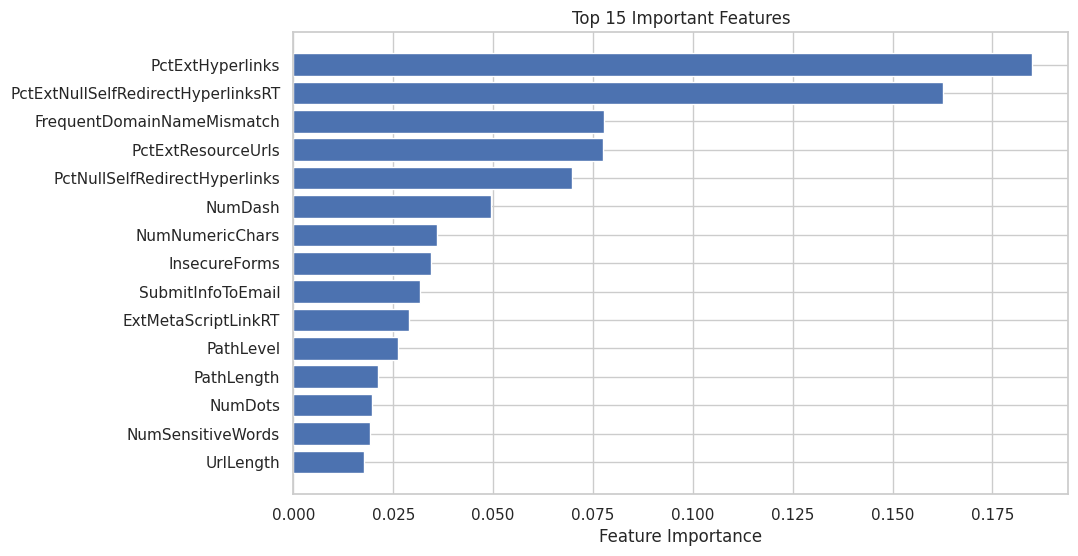

Final training features shape: (8000, 24)
Final test features shape: (2000, 24)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [6]:
# Step 6 — Feature Engineering for Phishing_Email.csv

# Convert scaled arrays back into DataFrames for feature selection
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# 1. Remove low-variance features
var_thresh = VarianceThreshold(threshold=0.01)  # keep features with enough variance
X_train_var = var_thresh.fit_transform(X_train_df)
X_test_var = var_thresh.transform(X_test_df)

selected_features_var = X_train_df.columns[var_thresh.get_support()]
print("Original features:", X_train_df.shape[1])
print("After variance threshold:", X_train_var.shape[1])

# 2. Remove highly correlated features (>0.95 correlation)
corr_matrix = X_train_df[selected_features_var].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

X_train_corr = X_train_df[selected_features_var].drop(columns=to_drop)
X_test_corr = X_test_df[selected_features_var].drop(columns=to_drop)

print("Dropped correlated features:", len(to_drop))
print("Remaining features:", X_train_corr.shape[1])

# 3. Feature importance with Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_corr, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]  # top 15 important features

plt.figure(figsize=(10, 6))
plt.title("Top 15 Important Features")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X_train_corr.columns[i] for i in indices])
plt.xlabel("Feature Importance")
plt.show()

# 4. Final reduced dataset (keep only important features)
sfm = SelectFromModel(rf, threshold="median", prefit=True)
X_train_final = sfm.transform(X_train_corr)
X_test_final = sfm.transform(X_test_corr)

print("Final training features shape:", X_train_final.shape)
print("Final test features shape:", X_test_final.shape)


In [7]:
# Step 7: Train-Test Split
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Safety: ensure no NaN labels
mask = y.notna()
X = X[mask]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)
print('Label counts in train:\n', y_train.value_counts())
print('Label counts in test:\n', y_test.value_counts())

Train shape: (8000, 48) Test shape: (2000, 48)
Label counts in train:
 CLASS_LABEL
0    4000
1    4000
Name: count, dtype: int64
Label counts in test:
 CLASS_LABEL
0    1000
1    1000
Name: count, dtype: int64


Logistic Regression -> Acc=0.945, Prec=0.936, Recall=0.954, F1=0.945, AUC=0.9814610000000001, Train=0.02s, Infer=0.00s
Random Forest -> Acc=0.985, Prec=0.986, Recall=0.983, F1=0.984, AUC=0.99869, Train=1.49s, Infer=0.06s
Decision Tree -> Acc=0.963, Prec=0.959, Recall=0.966, F1=0.963, AUC=0.9624999999999999, Train=0.05s, Infer=0.00s


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN -> Acc=0.963, Prec=0.943, Recall=0.986, F1=0.964, AUC=0.995, Train=5.90s, Infer=0.20s


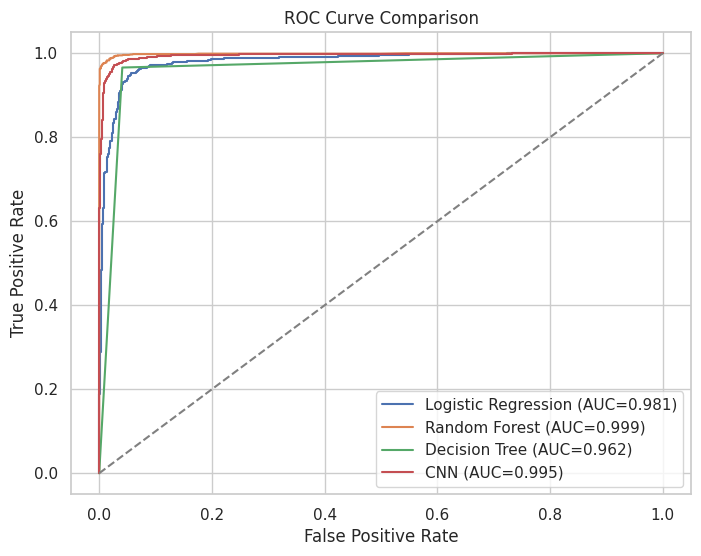

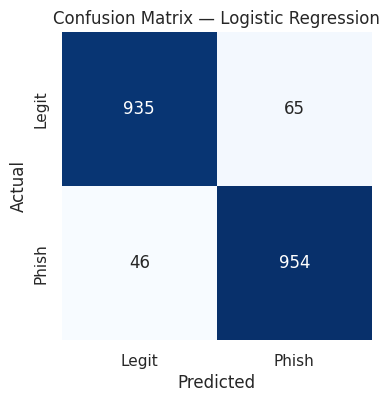

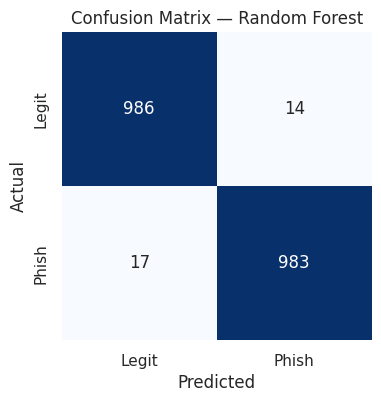

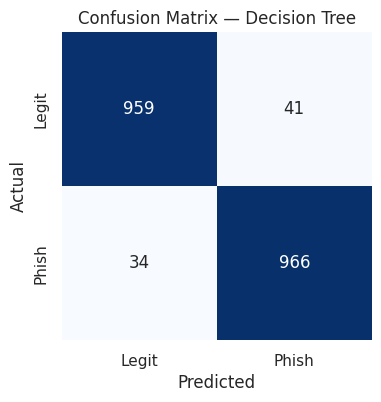

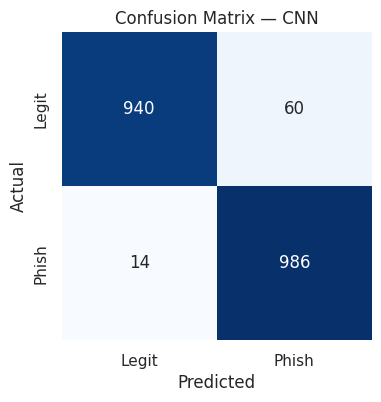

/tmp/ipython-input-2962832858.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[r["model"] for r in results], y=[r[metric] for r in results], palette="viridis")


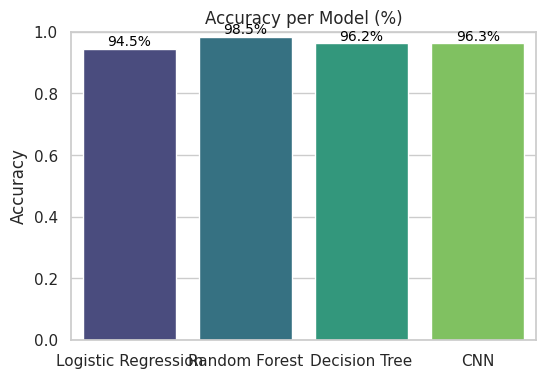

/tmp/ipython-input-2962832858.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[r["model"] for r in results], y=[r[metric] for r in results], palette="viridis")


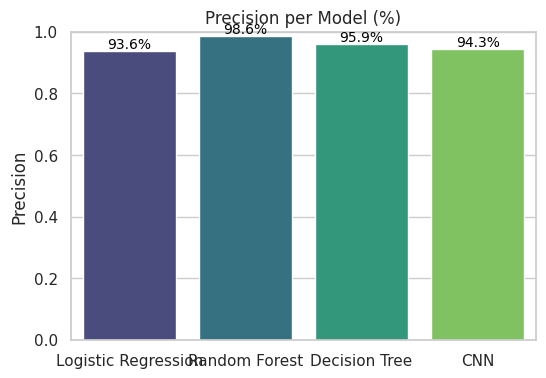

/tmp/ipython-input-2962832858.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[r["model"] for r in results], y=[r[metric] for r in results], palette="viridis")


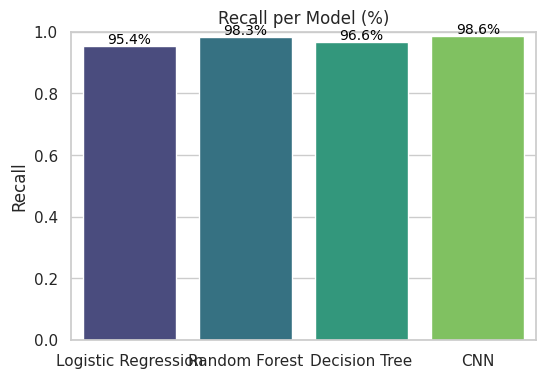

/tmp/ipython-input-2962832858.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=[r["model"] for r in results], y=[r[metric] for r in results], palette="viridis")


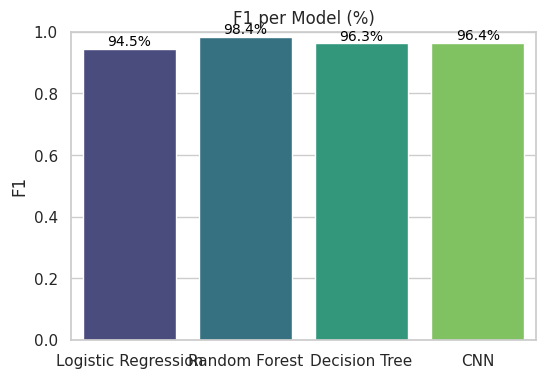

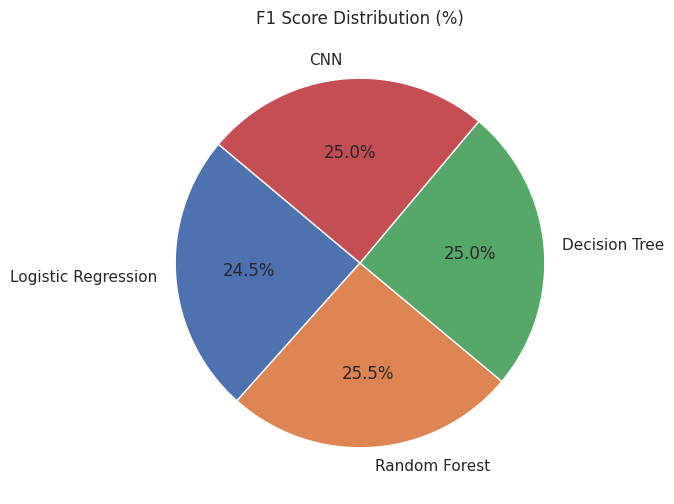

/tmp/ipython-input-2962832858.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="Train Time (s)", data=df_times, palette="coolwarm")


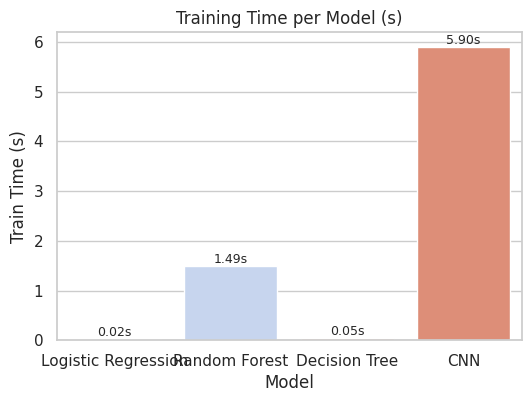

/tmp/ipython-input-2962832858.py:195: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="Inference Time (s)", data=df_times, palette="coolwarm")


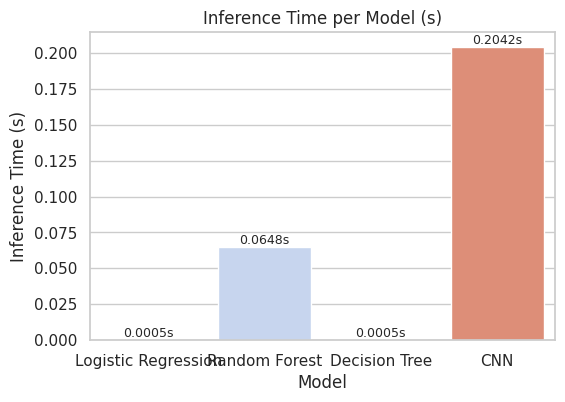

,Model,Train Time (s),Inference Time (s),Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.020042,0.000489,0.9445,0.936212,0.954,0.945022,0.981461
1,Random Forest,1.492115,0.064752,0.9845,0.985958,0.983,0.984477,0.998690
2,Decision Tree,0.046079,0.000525,0.9625,0.959285,0.966,0.962631,0.962500
3,CNN,5.900423,0.204169,0.9630,0.942639,0.986,0.963832,0.994863


from matplotlib import pyplot as plt
df_times['Train Time (s)'].plot(kind='hist', bins=20, title='Train Time (s)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_times['Inference Time (s)'].plot(kind='hist', bins=20, title='Inference Time (s)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_times['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_times['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_times.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_times.plot(kind='scatter', x='Train Time (s)', y='Inference Time (s)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_times.plot(kind='scatter', x='Inference Time (s)', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_times.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_times.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_times['Train Time (s)'].plot(kind='line', figsize=(8, 4), title='Train Time (s)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_times['Inference Time (s)'].plot(kind='line', figsize=(8, 4), title='Inference Time (s)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_times['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_times['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_times['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_times, x='Train Time (s)', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_times['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_times, x='Inference Time (s)', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_times['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_times, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_times['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_times, x='Precision', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Train Time (s)'].plot(kind='hist', bins=20, title='Train Time (s)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Inference Time (s)'].plot(kind='hist', bins=20, title='Inference Time (s)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='Train Time (s)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Train Time (s)', y='Inference Time (s)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Inference Time (s)', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Train Time (s)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Train Time (s)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Inference Time (s)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Inference Time (s)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Train Time (s)'].plot(kind='line', figsize=(8, 4), title='Train Time (s)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Inference Time (s)'].plot(kind='line', figsize=(8, 4), title='Inference Time (s)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='Train Time (s)', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Inference Time (s)', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [9]:
# Step 8 — Train and Evaluate Models (LogReg, RF, DT, CNN with metrics & plots)


# ---------------------------
# Classical ML Models
# ---------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

results = []

for name, model in models.items():
    # Training
    t0 = time.time()
    model.fit(X_train_final, y_train)
    train_time = time.time() - t0

    # Inference
    t1 = time.time()
    y_pred = model.predict(X_test_final)
    infer_time = time.time() - t1

    # Metrics
    y_score = model.predict_proba(X_test_final)[:,1] if hasattr(model, "predict_proba") else None
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_score) if y_score is not None else None
    fpr, tpr, _ = roc_curve(y_test, y_score) if y_score is not None else (None,None,None)

    results.append({
        "model": name,
        "cm": cm,
        "f1": f1,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "auc": auc_val,
        "train_time": train_time,
        "infer_time": infer_time,
        "fpr": fpr,
        "tpr": tpr
    })

    print(f"{name} -> Acc={acc:.3f}, Prec={prec:.3f}, Recall={rec:.3f}, "
          f"F1={f1:.3f}, AUC={auc_val}, Train={train_time:.2f}s, Infer={infer_time:.2f}s")


# ---------------------------
# CNN Model
# ---------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reshape input for CNN (samples, timesteps, features)
X_train_cnn = np.expand_dims(X_train_final, axis=2)
X_test_cnn = np.expand_dims(X_test_final, axis=2)

cnn = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation="relu", input_shape=(X_train_cnn.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Training CNN
t0 = time.time()
cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=0)
train_time = time.time() - t0

# Inference CNN
t1 = time.time()
y_score = cnn.predict(X_test_cnn, verbose=0).ravel()
y_pred = (y_score >= 0.5).astype(int)
infer_time = time.time() - t1

# Metrics
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc_val = roc_auc_score(y_test, y_score)
fpr, tpr, _ = roc_curve(y_test, y_score)

results.append({
    "model": "CNN",
    "cm": cm,
    "f1": f1,
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "auc": auc_val,
    "train_time": train_time,
    "infer_time": infer_time,
    "fpr": fpr,
    "tpr": tpr
})

print(f"CNN -> Acc={acc:.3f}, Prec={prec:.3f}, Recall={rec:.3f}, "
      f"F1={f1:.3f}, AUC={auc_val:.3f}, Train={train_time:.2f}s, Infer={infer_time:.2f}s")


# ---------------------------
# Combined ROC Curve
# ---------------------------
plt.figure(figsize=(8,6))
for res in results:
    if res["fpr"] is not None and res["tpr"] is not None:
        plt.plot(res["fpr"], res["tpr"], label=f"{res['model']} (AUC={res['auc']:.3f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


# ---------------------------
# Confusion Matrices per Model
# ---------------------------
for res in results:
    plt.figure(figsize=(4,4))
    sns.heatmap(res["cm"], annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Legit", "Phish"], yticklabels=["Legit", "Phish"])
    plt.title(f"Confusion Matrix — {res['model']}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# ---------------------------
# F1, Accuracy, Precision, Recall Bar Charts
# ---------------------------
metrics_to_plot = ["accuracy", "precision", "recall", "f1"]
for metric in metrics_to_plot:
    plt.figure(figsize=(6,4))
    ax = sns.barplot(x=[r["model"] for r in results], y=[r[metric] for r in results], palette="viridis")
    plt.ylabel(metric.capitalize())
    plt.title(f"{metric.capitalize()} per Model (%)")
    plt.ylim(0,1)
    # Add percentage labels
    for p in ax.patches:
        ax.annotate(f"{p.get_height()*100:.1f}%",
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color="black")
    plt.show()


# ---------------------------
# Pie Chart of F1-scores
# ---------------------------
plt.figure(figsize=(6,6))
plt.pie([r["f1"] for r in results], labels=[r["model"] for r in results], autopct="%1.1f%%", startangle=140)
plt.title("F1 Score Distribution (%)")
plt.show()


# ---------------------------
# Training & Inference Time Bar Charts
# ---------------------------
df_times = pd.DataFrame([{
    "Model": r["model"],
    "Train Time (s)": r["train_time"],
    "Inference Time (s)": r["infer_time"],
    "Accuracy": r["accuracy"],
    "Precision": r["precision"],
    "Recall": r["recall"],
    "F1 Score": r["f1"],
    "AUC": r["auc"]
} for r in results])

# Training Time
plt.figure(figsize=(6,4))
ax = sns.barplot(x="Model", y="Train Time (s)", data=df_times, palette="coolwarm")
plt.title("Training Time per Model (s)")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}s",
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.show()

# Inference Time
plt.figure(figsize=(6,4))
ax = sns.barplot(x="Model", y="Inference Time (s)", data=df_times, palette="coolwarm")
plt.title("Inference Time per Model (s)")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.4f}s",
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.show()


# ---------------------------
# Final Summary Table
# ---------------------------
df_times
